In [6]:
PATH = "C:/Users/Alexander/Documents/GitHub/14.38_Causal_ML/R_Notebooks/"
Image(filename = PATH + "example.png", width=100, height=100)

ERROR: Error in Image(filename = PATH + "example.png", width = 100, height = 100): could not find function "Image"


In [3]:
library(clusterGeneration)
library(mvtnorm)
library(randomForest)

set.seed(123) # = Seed for Replication = #
N=500 # = Number of observations = #
k=10 # = Number of variables in z = #
theta=0.5
b=1/(1:k)

# = Generate covariance matrix of z = #
sigma=genPositiveDefMat(k,"unifcorrmat")$Sigma
sigma=cov2cor(sigma)

Warning message:
"package 'randomForest' was built under R version 4.1.3"
randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.



OLS        Naive DML Cross-fiting DML 
       0.5467202        0.4186726        0.5115398

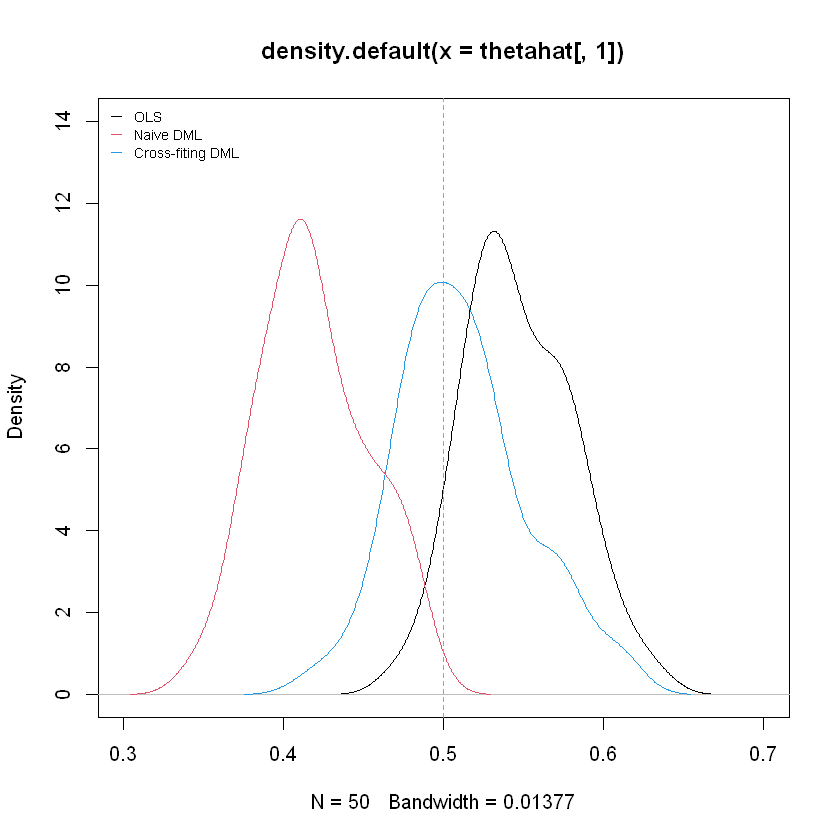

In [4]:
set.seed(123)
M=50 # = Number of Simumations = #

# = Matrix to store results = #
thetahat=matrix(NA,M,3)
colnames(thetahat)=c("OLS","Naive DML","Cross-fiting DML")

for(i in 1:M){
  z=rmvnorm(N,sigma=sigma) # = Generate z = #
  g=as.vector(cos(z%*%b)^2) # = Generate the function g = #
  m=as.vector(sin(z%*%b)+cos(z%*%b)) # = Generate the function m = #
  d=m+rnorm(N) # = Generate d = #
  y=theta*d+g+rnorm(N) # = Generate y = #

  # = OLS estimate = #
  OLS=coef(lm(y~d))[2]
  thetahat[i,1]=OLS

  # = Naive DML = #
  # = Compute ghat = #
  model=randomForest(z,y,maxnodes = 20)
  G=predict(model,z)
  # = Compute mhat = #
  modeld=randomForest(z,d,maxnodes = 20)
  M=predict(modeld,z)
  # = compute vhat as the residuals of the second model = #
  V=d-M
  # = Compute DML theta = #
  theta_nv=mean(V*(y-G))/mean(V*d)
  thetahat[i,2]=theta_nv

  # = Cross-fitting DML = #
  # = Split sample = #
  I=sort(sample(1:N,N/2))
  IC=setdiff(1:N,I)
  # = compute ghat on both sample = #
  model1=randomForest(z[IC,],y[IC],maxnodes = 10)
  model2=randomForest(z[I,],y[I], maxnodes = 10)
  G1=predict(model1,z[I,])
  G2=predict(model2,z[IC,])

  # = Compute mhat and vhat on both samples = #
  modeld1=randomForest(z[IC,],d[IC],maxnodes = 10)
  modeld2=randomForest(z[I,],d[I],maxnodes = 10)
  M1=predict(modeld1,z[I,])
  M2=predict(modeld2,z[IC,])
  V1=d[I]-M1
  V2=d[IC]-M2

  # = Compute Cross-Fitting DML theta
  theta1=mean(V1*(y[I]-G1))/mean(V1*d[I])
  theta2=mean(V2*(y[IC]-G2))/mean(V2*d[IC])
  theta_cf=mean(c(theta1,theta2))
  thetahat[i,3]=theta_cf

}

colMeans(thetahat) # = check the average theta for all models = #

##              OLS        Naive DML Cross-fiting DML
##        0.5465718        0.4155583        0.5065751

# = plot distributions = #
plot(density(thetahat[,1]),xlim=c(0.3,0.7),ylim=c(0,14))
lines(density(thetahat[,2]),col=2)
lines(density(thetahat[,3]),col=4)
abline(v=0.5,lty=2,col=3)
legend("topleft",legend=c("OLS","Naive DML","Cross-fiting DML"),col=c(1,2,4),lty=1,cex=0.7,seg.len = 0.7,bty="n")